In [1]:
# this path append is for binder only
import sys
sys.path.append("../../")

#spectrome modules
# from spectrome.forward import runforward, runforward_spatialcorrelation_topalpha
from spectrome.utils import functions, path
from spectrome.brain import Brain
from spectrome.stability import localstability
from spectrome.forward import network_transfer_macrostable as nt
# from spectrome.forward import network_transfer_macrostable_microintensity as nt_nostimulus

#generic modules
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import pandas as pd
import seaborn as sns
import pickle as pkl
from scipy import stats
from scipy.stats import pearsonr
from scipy.io import loadmat
from sklearn.preprocessing import minmax_scale

from scipy.io import savemat

plt.rcParams.update({
    "mathtext.fontset": "stix",
    "font.family": "STIXGeneral",
    "xtick.labelsize": 12,
    "ytick.labelsize": 12
})

In [2]:
sleep = loadmat('/data/rajlab1/user_data/parul/sleep_files/PSD_pmtm_RP.mat')

Data = sleep['PSD']

N1 = Data[:,0]
N2 = Data[:,1]
wake = Data[:,3]

temp = np.squeeze(N1[0][1])
psd_N1 = temp['REL_psdx']

fvec = temp['freqs'][0][:,0]

print("shape of N1:", psd_N1.shape)
print("shape of fvec:", fvec.shape)

# Take frequencies till 35 Hz
fvec = fvec[0:30]

print("after cutting off till 30 Hz fvec shape:", fvec.shape)
print("Last frequency in fvec:", fvec[-1])

nsubs = len(psd_N1)
nroi = len(psd_N1[0])
print("nsubs len:", nsubs)
print("nroi len:", nroi)

temp = np.squeeze(N2[0][1])
psd_N2 = temp['REL_psdx']

print("shape of N2:", psd_N2.shape)

temp = np.squeeze(wake[0][1])
psd_wake = temp['REL_psdx']

print("shape of wake:", psd_wake.shape)

# cortical areas with MEG collected + source reconstructed
rois_with_MEG = np.arange(0,nroi)

sc_bn = loadmat("/data/rajlab1/shared_data/datasets/brainnetome_template/SC_HC_BN_template.mat")

conn = sc_bn['SC_template']
dist = sc_bn['Dist_template']

# create spectrome brain:
brain = Brain.Brain()
# brain.reducedConnectome = conn
brain.connectome = conn
brain.distance_matrix = dist
brain.bi_symmetric_c_BN()
brain.reduce_extreme_dir()

mica_micro_intensity = np.squeeze(loadmat('/data/rajlab1/shared_data/datasets/MICA/BN_MICA_qT1_mean_normalized.mat')['qT1_mean'])

lpf = np.array([1, 2, 3, 2, 1])
lpf = lpf/np.sum(lpf)

shape of N1: (14,)
shape of fvec: (40,)
after cutting off till 30 Hz fvec shape: (30,)
Last frequency in fvec: 30
nsubs len: 14
nroi len: 246
shape of N2: (14,)
shape of wake: (14,)


In [5]:
wake_params = np.loadtxt("/data/rajlab1/user_data/parul/spectromeP_results/results_globalSGM/alpha_experiments/sleep_wake_orgSGM_relspec_roivolnorm_reducedconnectome.csv", delimiter=",")
N2_params = np.loadtxt("/data/rajlab1/user_data/parul/spectromeP_results/results_globalSGM/alpha_experiments/sleep_N2_orgSGM_relspec_roivolnorm_reducedconnectome.csv", delimiter=",")

wake_params_sorted = wake_params[np.argsort(wake_params[:,10])]

w_chosen = wake_params_sorted

df_wake=pd.DataFrame({'tau_e':w_chosen[:,0], 'tau_i':w_chosen[:,1], 'alpha':w_chosen[:,2], 'speed':w_chosen[:,3], 'gei':w_chosen[:,4], 'gii':w_chosen[:,5], 'tauC':w_chosen[:,6]})


N2_params_sorted = N2_params[np.argsort(N2_params[:,10])]

w_chosen = N2_params_sorted

df_N2=pd.DataFrame({'tau_e':w_chosen[:,0], 'tau_i':w_chosen[:,1], 'alpha':w_chosen[:,2], 'speed':w_chosen[:,3], 'gei':w_chosen[:,4], 'gii':w_chosen[:,5], 'tauC':w_chosen[:,6]})


In [6]:
def run_local_coupling_forward(brain, params, freqs, stimulus_roi, w_var, w_means):

    eigenvalues = []
    eigenvectors = []
    frequency_response = []
    model_out = []
    

    for freq in freqs:
        w = 2 * np.pi * freq
        freq_model, freq_resp, eig_val, eig_vec = nt.network_transfer_local_alpha(
            brain, params, w, stimulus_roi, w_var, w_means
        )
        frequency_response.append(freq_resp)
        eigenvalues.append(eig_val)
        eigenvectors.append(eig_vec)
        model_out.append(freq_model)
       

    frequency_response = np.asarray(frequency_response)
    eigenvalues = np.asarray(eigenvalues)
    eigenvectors = np.asarray(eigenvectors)
    model_out = np.transpose(np.asarray(model_out))
   

    return model_out, frequency_response, eigenvalues, eigenvectors

def run_local_coupling_forward_Xk(brain, params, freqs, PSD, SC, rois_with_MEG, band, stimulus_roi, w_var, w_means):

    if band == "alpha":
        freqband = np.where((freqs>=8) & (freqs<=12))[0]
    if band == "beta":
        freqband = np.where((freqs>=13) & (freqs<=25))[0]

    eigvec_ns = np.zeros((len(rois_with_MEG),len(freqband)))

    for i in range(len(freqband)):
        w = 2 * np.pi * freqs[freqband[i]]
        eigenvectors_ns, _, _, _ = nt.network_transfer_local_alpha(
            brain, params, w, stimulus_roi, w_var, w_means
        )

        eigvec_ns[:,i] = eigenvectors_ns[rois_with_MEG]
        # eigvec_ns[:,i] = eigenvectors_ns

    eigvec_ns_summed = np.sum(eigvec_ns,axis = 1)

    # eigvec_summed = eigvec_ns_summed/np.linalg.norm(eigvec_ns_summed)

    summed_PSD = np.sum(PSD[:,freqband], axis = 1)

    # summed_PSD = summed_PSD/np.linalg.norm(summed_PSD)
    
    return summed_PSD, eigvec_ns_summed    

In [7]:
def getpsd(cdk,psd,rois_with_MEG,fvec,lpf,s,df_in, stimulus_roi, w_var, w_means):

    F_ind = psd[s][:,0:30] # grab current subject's MEG
    
    brain.ntf_params["tau_e"] = df_in['tau_e'][s]/1000
    brain.ntf_params["tau_i"] = df_in['tau_i'][s]/1000
    brain.ntf_params["alpha"] = df_in['alpha'][s]
    brain.ntf_params["speed"] = df_in['speed'][s]
    brain.ntf_params["gei"] = df_in['gei'][s]
    brain.ntf_params["gii"] = df_in['gii'][s]
    brain.ntf_params["tauC"] = df_in['tauC'][s]/1000

    model_spectrum, _, _, _ = run_local_coupling_forward(brain, brain.ntf_params, fvec, stimulus_roi, w_var, w_means)

    model_spectrum = model_spectrum[rois_with_MEG,:]
    
    filfinal = 0

    for g in range(len(model_spectrum)):
        spectrum = np.abs(model_spectrum[g,:])        
        filtered = functions.mag2db(spectrum)
        filfinal += filtered

    filfinal = filfinal/len(model_spectrum)

    # Return average psd for a specific subject (old or new depending on choice)

    meg_spat, model_spat = run_local_coupling_forward_Xk(brain, brain.ntf_params, fvec, F_ind, 86, rois_with_MEG,"alpha", stimulus_roi, w_var, w_means)
    
    return filfinal, meg_spat, model_spat

In [11]:
stimulus_roi = np.array([])

nsubs = len(w_chosen[:,0])
new_spectra = 0
new_spectra2 = 0
org_spectra_overall = 0
meg_spat_tot = 0
model_spat_tot = 0

w_var = 1
w_means = 0


for i in range(nsubs):
    
    spec_predicted, meg_spat, model_spat = getpsd(conn,psd_N2,rois_with_MEG,fvec,lpf,i,df_N2, stimulus_roi, w_var, w_means)
    new_spectra += spec_predicted
    meg_spat_tot += meg_spat
    model_spat_tot += model_spat

    org_spectra = 0
    for g in rois_with_MEG:
        # spectrum = ind_psd[g,:,i]
        spectrum = functions.mag2db(psd_N2[i][g,0:30])
#         spectrum = (spectrum - np.mean(spectrum))/(np.std(spectrum))
        org_spectra += spectrum
    org_spectra = org_spectra/len(rois_with_MEG)

    org_spectra_overall += org_spectra
    

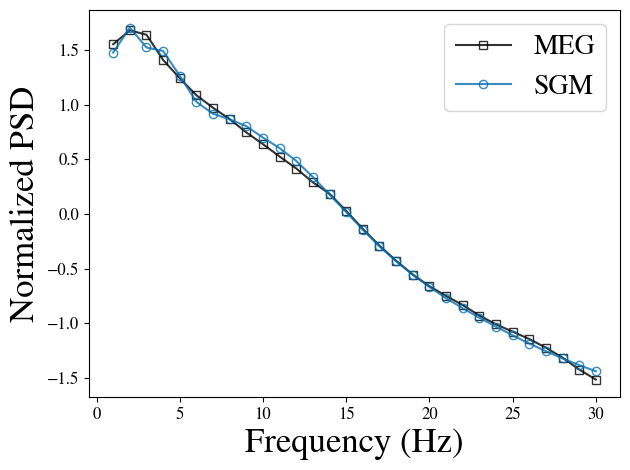

In [12]:
new_c = '#0571b0'

new_normalized = (new_spectra - np.mean(new_spectra))/(np.std(new_spectra))
org_normalized = (org_spectra_overall - np.mean(org_spectra_overall))/(np.std(org_spectra_overall))

colorp = sns.color_palette("colorblind",n_colors=3)

fig, ax = plt.subplots()


ax.plot(fvec,org_normalized,linestyle = '-',marker = 's',fillstyle = 'none',color = 'k', label = "MEG", alpha = 0.8)
ax.plot(fvec,new_normalized,linestyle = '-',marker = 'o',fillstyle = 'none',color = new_c, label = "SGM", alpha = 0.8)

ax.legend(fontsize = 20)
ax.set_xlabel('Frequency (Hz)', fontsize = 25)
ax.set_ylabel('Normalized PSD', fontsize = 25)

plt.tight_layout()

In [13]:
# filename = f'/data/rajlab1/user_data/parul/spectrome-spatial_results/results/spatial/sleep/N2_orgSGM_roivolnorm_relspec_reducedconnectome_alpha_model.mat'
# savemat(filename, {'eigvec':model_spat_tot})

# filename = f'/data/rajlab1/user_data/parul/spectrome-spatial_results/results/spatial/sleep/wake_qT1_relspec_alpha_meg.mat'
# savemat(filename, {'eigvec':meg_spat_tot})

In [14]:
st_wake = []
st_N2 = []

for i in range(nsubs):
    brain.ntf_params["tau_e"] = df_wake['tau_e'][i]
    brain.ntf_params["tau_i"] = df_wake['tau_i'][i]
    brain.ntf_params["gei"] = df_wake['gei'][i]
    brain.ntf_params["gii"] = df_wake['gii'][i]
    # st = localstability_microint_receptors_allrois.local_stability(brain.ntf_params,mica_micro_intensity,ex_template,inh_template)
    # st = localstability_microintensity_allrois.local_stability(brain.ntf_params,mica_micro_intensity)
    st = localstability.local_stability(brain.ntf_params,mica_micro_intensity)
    st_wake.append(st)
    
    brain.ntf_params["tau_e"] = df_N2['tau_e'][i]
    brain.ntf_params["tau_i"] = df_N2['tau_i'][i]
    brain.ntf_params["gei"] = df_N2['gei'][i]
    brain.ntf_params["gii"] = df_N2['gii'][i]
    # st = localstability_microint_receptors_allrois.local_stability(brain.ntf_params,mica_micro_intensity,ex_template,inh_template)
    # st = localstability_microintensity_allrois.local_stability(brain.ntf_params,mica_micro_intensity)
    st = localstability.local_stability(brain.ntf_params,mica_micro_intensity)
    st_N2.append(st)

In [15]:
print(np.where(np.array(st_wake)>0))
print(np.where(np.array(st_N2)>0))

(array([], dtype=int64),)
(array([], dtype=int64),)
